# Práctica 10: Clasificación de datos con sklearn
## Gabriela Sánchez Y.

El objetivo en esta práctica es aplicar distintos métodos de clasificación a alguna división de interés de los datos estudiados, evaluar dicha clasificación e intentar mejorarla con un ajuste de parámetros si es que se tienen.

Una clasificación asigna de manera automática datos en grupos previamente conocidos según sus atributos. Para el caso de estudio, se determinan dos clasificaciones binarias 
- sexo del agresor,
- si la víctima es mayor o menor de edad.

Se usará el 60% de los datos para entrenar y el 40% para validar. Para la clasificación se consideran los siguientes atributos:
- sexo del agresor
- sexo y edad de la víctima
- mes y hora del incidente,
tomando únicamente los incidentes para los cuales solo hay una víctima y un agresor.

In [1]:
import pandas as pd
datos = pd.read_csv("/home/saphira/Desktop/datos/vf_p5.csv")
datos.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,mes,mpio,col,delito,mod,fecha,violencia,tipo,hora,carpeta,...,escolaridad,atencion_psi,atencion_med,agresor,sexo_a,edad_a,edo_civil_a,ocupacion_a,escolaridad_a,atencion_psi.1
0,1,CADEREYTA JIMÉNEZ,VALLE DE LOS ENCINOS,VIOLENCIA FAMILIAR,VIOLENCIA FAMILIAR,2018/01/01,CON,"FÍSICA, PSICOLOGICA",N,3/2018,...,SECUNDARIA,SI,NO,1.0,M,36 a 40,UNIÓN LIBRE,PRESTADOR DE SERVICIOS,SECUNDARIA,NO
1,1,CADEREYTA JIMÉNEZ,VALLE DEL ROBLE,VIOLENCIA FAMILIAR,VIOLENCIA FAMILIAR,2017/12/27,CON,"FÍSICA, PSICOLOGICA",M,4/2018,...,SECUNDARIA,SI,NO,1.0,M,21 a 25,UNIÓN LIBRE,SIN OFICIO,SECUNDARIA,NO
2,1,CADEREYTA JIMÉNEZ,VALLE DEL ROBLE,VIOLENCIA FAMILIAR,VIOLENCIA FAMILIAR,2018/01/01,CON,"PSICOLOGICA, PATRIMONIAL",M,2/2018,...,PREPARATORIA,SI,NO,1.0,M,41,CASADO,CHOFER,SECUNDARIA,NO
3,1,CIÉNEGA DE FLORES,LOMAS DE CIENEGA,VIOLENCIA FAMILIAR,VIOLENCIA FAMILIAR,2017/12/22,CON,"FÍSICA, PSICOLOGICA",M,5/2018,...,PREPARATORIA,SI,NO,1.0,M,34,UNIÓN LIBRE,EMPLEADO,PRIMARIA,NO
4,1,CIÉNEGA DE FLORES,REAL DEL SOL,VIOLENCIA FAMILIAR,VIOLENCIA FAMILIAR,2017/12/25,CON,FÍSICA,T,4/2018,...,SECUNDARIA,SI,NO,1.0,M,45,CASADO,EMPLEADO,PREPARATORIA,NO


In [2]:
from numpy import isnan
datos = datos.loc[datos['victima'] == 1]
datos = datos.loc[datos['agresor'] == 1]
datos = datos.loc[~isnan(datos.agresor)]
datos = datos.loc[~isnan(datos.victima)]

prueba = datos.edad_v
limpios = []
for dato in prueba:
    s = str(dato).replace(",", " ")
    pedazos = s.split()   
    while "a" in pedazos:
        pos = pedazos.index("a")
        desde = int(pedazos[pos - 1])
        hasta = int(pedazos[pos + 1])
        prom = (desde + hasta) // 2
        limpios.append(prom)
        pedazos = pedazos[:(pos - 1)] + pedazos[(pos + 2):]
    limpios += pedazos
datos.edad_v = list(limpios)
datos = datos.loc[datos['edad_v'] != 'NE']

datos.hora.replace(to_replace = dict(M = 0, T = 1, N = 2), inplace = True)
datos.sexo_a.replace(to_replace = dict(M = 0, F = 1), inplace = True)
datos.sexo_v.replace(to_replace = dict(M = 0, F = 1), inplace = True)
datos.edad_v = [int(v) for v in datos.edad_v]

d = {'sa': datos.sexo_a, 'sv': datos.sexo_v, 'ev': datos.edad_v, 'mes': datos.mes, 'hr': datos.hora}
d = pd.DataFrame(data = d)
d.head()
d.to_csv('vf_p10.csv', header=True, index=False)

### Sexo 

1    12934
2     1819
Name: etiquetas, dtype: int64


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


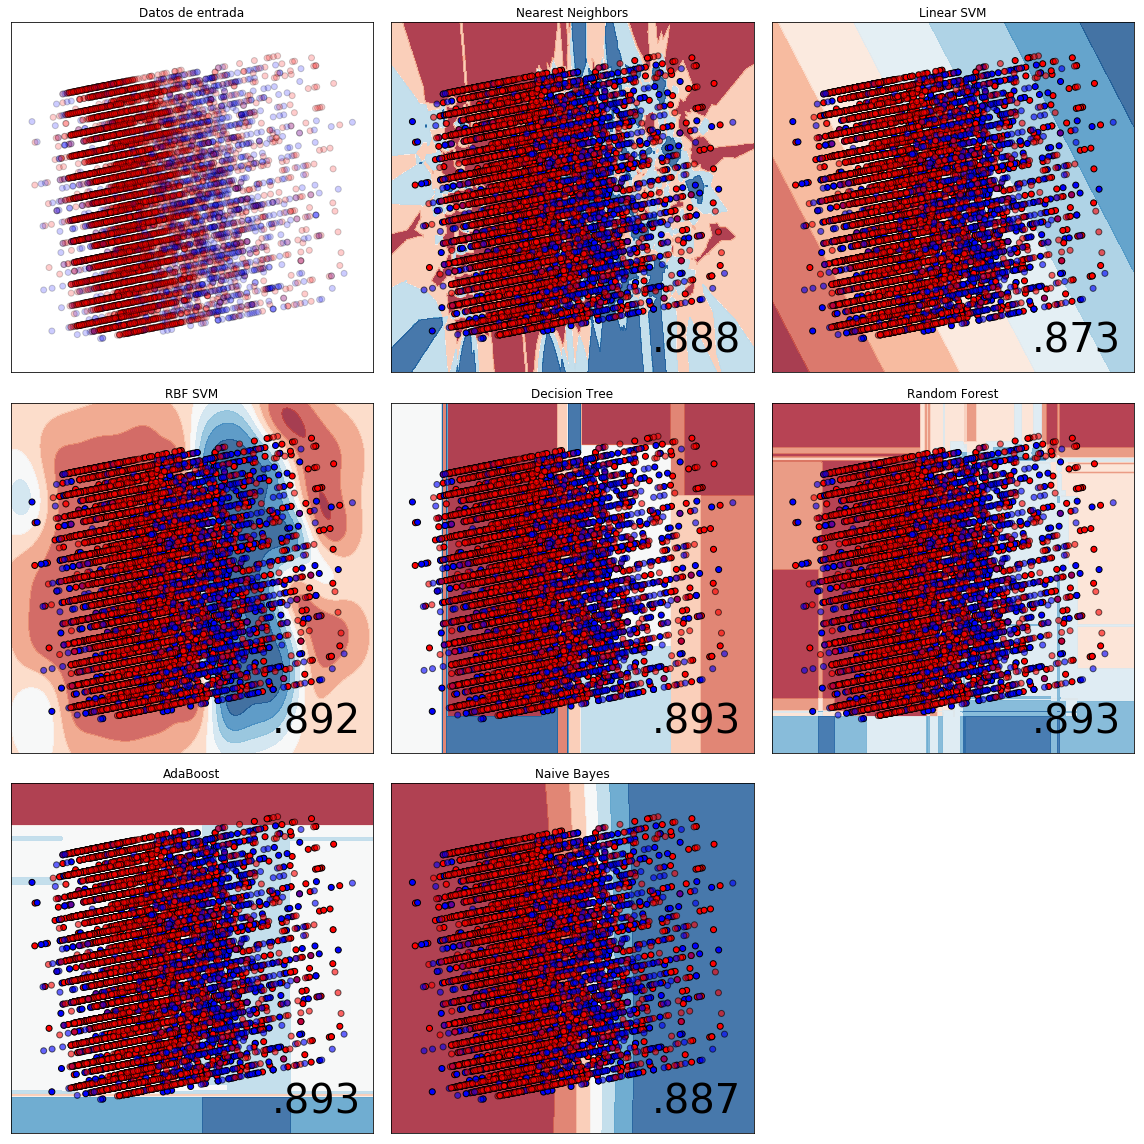

In [9]:
import ssl
from math import ceil, sqrt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from numpy import isnan, nan, arange, meshgrid, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
                                                                                                                  
if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

pri = d.sa == 0
seg = d.sa == 1

d['etiquetas'] = [1 if  pri[i] else 2 if seg[i] else "NA" for i in pri.keys()] # etiquetas
print(d.etiquetas.value_counts())
y = d.etiquetas
xVars = ['hr', 'mes', 'ev','sv']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2) # pedimos uno bidimensional
X = pca.fit_transform(x)

# código de https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3),SVC(kernel="linear", C=0.025), SVC(gamma=2, C=1), \
             DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
               AdaBoostClassifier(), GaussianNB()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42) # división
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
k = int(ceil(sqrt(len(classifiers) + 1)))
xx, yy = meshgrid(arange(x_min, x_max, 0.01), arange(y_min, y_max, 0.01))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.rcParams["figure.figsize"] = [16, 16]
figure = plt.figure()
ax = plt.subplot(k, k, 1)
ax.set_title("Datos de entrada")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.2, edgecolors='k') # entrenamiento
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.2, edgecolors='k') # validación
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i = 2
for name, clf in zip(names, classifiers):
    ax = plt.subplot(k, k, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score).lstrip('0'), size=40, horizontalalignment='right')
    i += 1
plt.tight_layout()
plt.show()

Los clasificadores que tienen el mayor puntaje de precisión son _Decision Tree_ y _AdaBoost_. Para un mejor análisis, hay que revisar las matrices de confusión.

In [4]:
from sklearn import metrics
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print(name, clf.score(X_test, y_test))
    expected, predicted = y_test, clf.predict(X_test)
    print(metrics.classification_report(expected, predicted))
    print(metrics.confusion_matrix(expected, predicted))
    print('-' * 60)

Nearest Neighbors 0.8880040664181633
              precision    recall  f1-score   support

           1       0.92      0.95      0.94      5152
           2       0.57      0.47      0.52       750

   micro avg       0.89      0.89      0.89      5902
   macro avg       0.75      0.71      0.73      5902
weighted avg       0.88      0.89      0.88      5902

[[4888  264]
 [ 397  353]]
------------------------------------------------------------
Linear SVM 0.8729244323957981
              precision    recall  f1-score   support

           1       0.87      1.00      0.93      5152
           2       0.00      0.00      0.00       750

   micro avg       0.87      0.87      0.87      5902
   macro avg       0.44      0.50      0.47      5902
weighted avg       0.76      0.87      0.81      5902

[[5152    0]
 [ 750    0]]
------------------------------------------------------------


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RBF SVM 0.8922399186716368
              precision    recall  f1-score   support

           1       0.92      0.96      0.94      5152
           2       0.60      0.46      0.52       750

   micro avg       0.89      0.89      0.89      5902
   macro avg       0.76      0.71      0.73      5902
weighted avg       0.88      0.89      0.89      5902

[[4922  230]
 [ 406  344]]
------------------------------------------------------------
Decision Tree 0.8932565232124704
              precision    recall  f1-score   support

           1       0.93      0.95      0.94      5152
           2       0.60      0.47      0.53       750

   micro avg       0.89      0.89      0.89      5902
   macro avg       0.76      0.71      0.73      5902
weighted avg       0.88      0.89      0.89      5902

[[4918  234]
 [ 396  354]]
------------------------------------------------------------
Random Forest 0.8866485936970518
              precision    recall  f1-score   support

           1       0.9

Un buen desempeño del modelo se representaría en una matriz de confusión con valores grandes en el diagonal y valores bajos en otros lados. Ninguno de los modelos dió resultados muy buenos, como se mencionó anteriormente, los modelos con mayor puntaje de precisión son _Decision Tree_ y _AdaBoost_ con 0.893. 

El clasificador _Linear SVM_ tiene buen desempeño clasificando todos los incidentes en los que el sexo es masculino, sin embargo, falla en todos los casos contrarios. En general, parece que para los casos en los que el sexo del agresor es femenino son más dificiles de clasificar.

Ahora, se revisará qué pasa con los resultados si no se especifica semilla a la división entre conjuntos de entrenamiento y prueba.

In [5]:
pri = d.sa == 0
seg = d.sa == 1

d['etiquetas'] = [1 if  pri[i] else 2 if seg[i] else "NA" for i in pri.keys()] # etiquetas
print(d.etiquetas.value_counts())
y = d.etiquetas
xVars = ['hr', 'mes', 'ev','sv']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4) # cada ejecución tiene una división al azar
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_m = clf.predict(X_test)
    print(name, clf.score(X_test, y_test))
    expected, predicted = y_test, clf.predict(X_test)
    print(metrics.confusion_matrix(y_test, y_m))
    print('-' * 60)

1    12934
2     1819
Name: etiquetas, dtype: int64


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Nearest Neighbors 0.8896984073195527
[[4944  262]
 [ 389  307]]
------------------------------------------------------------
Linear SVM 0.8820738732633006
[[5206    0]
 [ 696    0]]
------------------------------------------------------------
RBF SVM 0.8985089800067774
[[4972  234]
 [ 365  331]]
------------------------------------------------------------
Decision Tree 0.9008810572687225
[[4951  255]
 [ 330  366]]
------------------------------------------------------------
Random Forest 0.896645205015249
[[4980  226]
 [ 384  312]]
------------------------------------------------------------
AdaBoost 0.894103693663165
[[4903  303]
 [ 322  374]]
------------------------------------------------------------
Naive Bayes 0.8939342595730261
[[5036  170]
 [ 456  240]]
------------------------------------------------------------


No se obtuvo una mejora. El mayor puntaje de precisión alcanzado en este caso es menor que en el caso anterior. 

### Edad

Ahora se repite el procedimiento anterior, solo que ahora se busca clasificar sí o no en el incidente la víctima es menor o mayor de edad.

1    14204
0      549
Name: etiquetas, dtype: int64


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


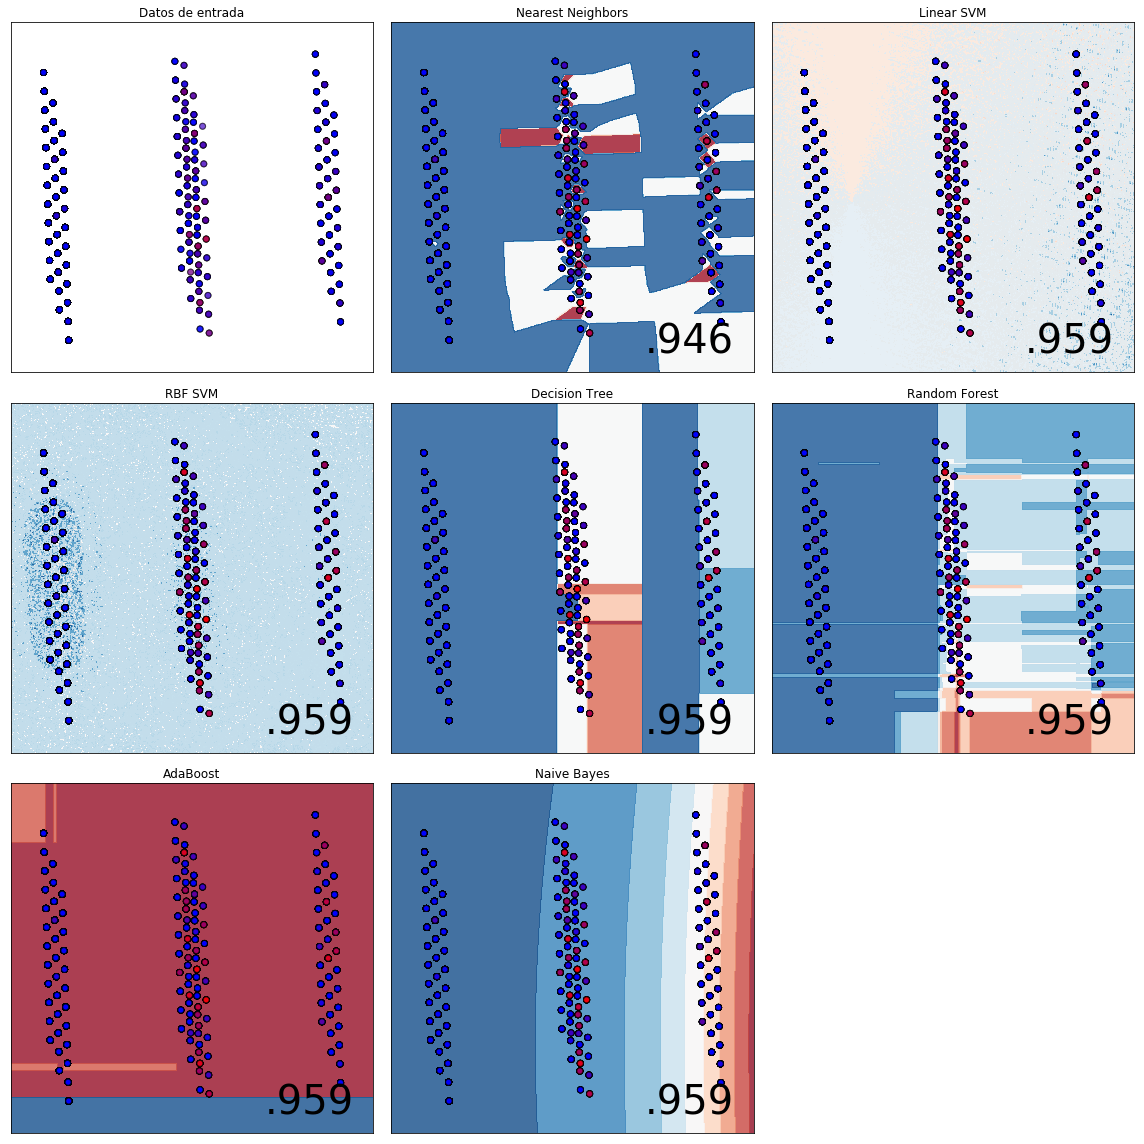

In [6]:
pri = d.ev >= 18
d['etiquetas'] = [1 if  pri[i] else 0 for i in pri.keys()] # etiquetas
print(d.etiquetas.value_counts())
y = d.etiquetas
xVars = ['hr', 'mes', 'sa', 'sv']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)
pca = PCA(n_components = 2) # pedimos uno bidimensional
X = pca.fit_transform(x)

# código de https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html 
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", \
         "Decision Tree", "Random Forest", "AdaBoost", "Naive Bayes"]
classifiers = [KNeighborsClassifier(3),SVC(kernel="linear", C=0.025), SVC(gamma=2, C=1), \
             DecisionTreeClassifier(max_depth=5), RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), \
               AdaBoostClassifier(), GaussianNB()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42) # división
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
k = int(ceil(sqrt(len(classifiers) + 1)))
xx, yy = meshgrid(arange(x_min, x_max, 0.01), arange(y_min, y_max, 0.01))
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.rcParams["figure.figsize"] = [16, 16]
figure = plt.figure()
ax = plt.subplot(k, k, 1)
ax.set_title("Datos de entrada")
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, alpha=0.2, edgecolors='k') # entrenamiento
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.2, edgecolors='k') # validación
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i = 2
for name, clf in zip(names, classifiers):
    ax = plt.subplot(k, k, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.3f' % score).lstrip('0'), size=40, horizontalalignment='right')
    i += 1
plt.tight_layout()
plt.show()

In [7]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_m = clf.predict(X_test)
    print(name, clf.score(X_test, y_test))
    expected, predicted = y_test, clf.predict(X_test)
    print(metrics.confusion_matrix(y_test, y_m))
    print('-' * 60)

Nearest Neighbors 0.9457810911555405
[[  19  224]
 [  96 5563]]
------------------------------------------------------------
Linear SVM 0.9588275160962385
[[   0  243]
 [   0 5659]]
------------------------------------------------------------
RBF SVM 0.9588275160962385
[[   0  243]
 [   0 5659]]
------------------------------------------------------------
Decision Tree 0.9588275160962385
[[   0  243]
 [   0 5659]]
------------------------------------------------------------
Random Forest 0.9588275160962385
[[   0  243]
 [   0 5659]]
------------------------------------------------------------
AdaBoost 0.9588275160962385
[[   0  243]
 [   0 5659]]
------------------------------------------------------------
Naive Bayes 0.9588275160962385
[[   0  243]
 [   0 5659]]
------------------------------------------------------------


El modelo que tiene el menor desempeño de acuerdo al puntaje de precisión es el clasificador _Nearest Neighbors_, aunque al revisar las matrices de confusión se aprecia que todos los otros modelos no acertaron en clasificar los incidentes donde la víctima es menor de edad. _Nearest Neighbors_ es el único que logra clasificar 19 de éstos incidentes.

In [8]:
pri = d.ev >= 18
d['etiquetas'] = [1 if  pri[i] else 0 for i in pri.keys()] # etiquetas
print(d.etiquetas.value_counts())
y = d.etiquetas
xVars = ['hr', 'mes', 'sa', 'sv']
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4) # cada ejecución tiene una división al azar
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_m = clf.predict(X_test)
    print(name, clf.score(X_test, y_test))
    expected, predicted = y_test, clf.predict(X_test)
    print(metrics.confusion_matrix(y_test, y_m))
    print('-' * 60)

1    14204
0      549
Name: etiquetas, dtype: int64


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Nearest Neighbors 0.9576414774652661
[[  13  225]
 [  25 5639]]
------------------------------------------------------------
Linear SVM 0.9596746865469332
[[   0  238]
 [   0 5664]]
------------------------------------------------------------
RBF SVM 0.9596746865469332
[[   0  238]
 [   0 5664]]
------------------------------------------------------------
Decision Tree 0.9596746865469332
[[   0  238]
 [   0 5664]]
------------------------------------------------------------
Random Forest 0.9596746865469332
[[   0  238]
 [   0 5664]]
------------------------------------------------------------
AdaBoost 0.9596746865469332
[[   0  238]
 [   0 5664]]
------------------------------------------------------------
Naive Bayes 0.9596746865469332
[[   0  238]
 [   0 5664]]
------------------------------------------------------------


Ahora que no se especifica semilla a la división entre conjuntos de entrenamiento y prueba, se obtienen mejores resultados en el puntaje de precisión.